In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
%cd ..

/cis/home/dpacker/my_documents/equivariant-attention


In [81]:
from models import vanilla_attention, positional_encodings
import jax.numpy as jnp
import jax
from matplotlib import pyplot as plt, axes
rng = jax.random.PRNGKey(seed=1)
rngs = jax.random.split(rng, 10)

pairwise_dists = lambda X : jnp.linalg.norm(X[:, None, :] - X[None, :, :], axis = -1)
omega = jax.jit(lambda delta, orig_dists, enc_dists : jnp.max(orig_dists * (enc_dists <= delta)))
batched_omega = jax.vmap(omega, in_axes=(0, None, None))

def plot_omega(domain: jnp.ndarray, method: str, ax: axes.Axes):
  encoded_domain = positional_encodings.positional_encoding(domain, method = method)
  original_distances = pairwise_dists(domain)
  encoded_distances = pairwise_dists(encoded_domain)
  deltas = jnp.linspace(0, 1, num = 100)
  omega_values = batched_omega(deltas, original_distances, encoded_distances)
  ax.plot(deltas, omega_values, label = method)

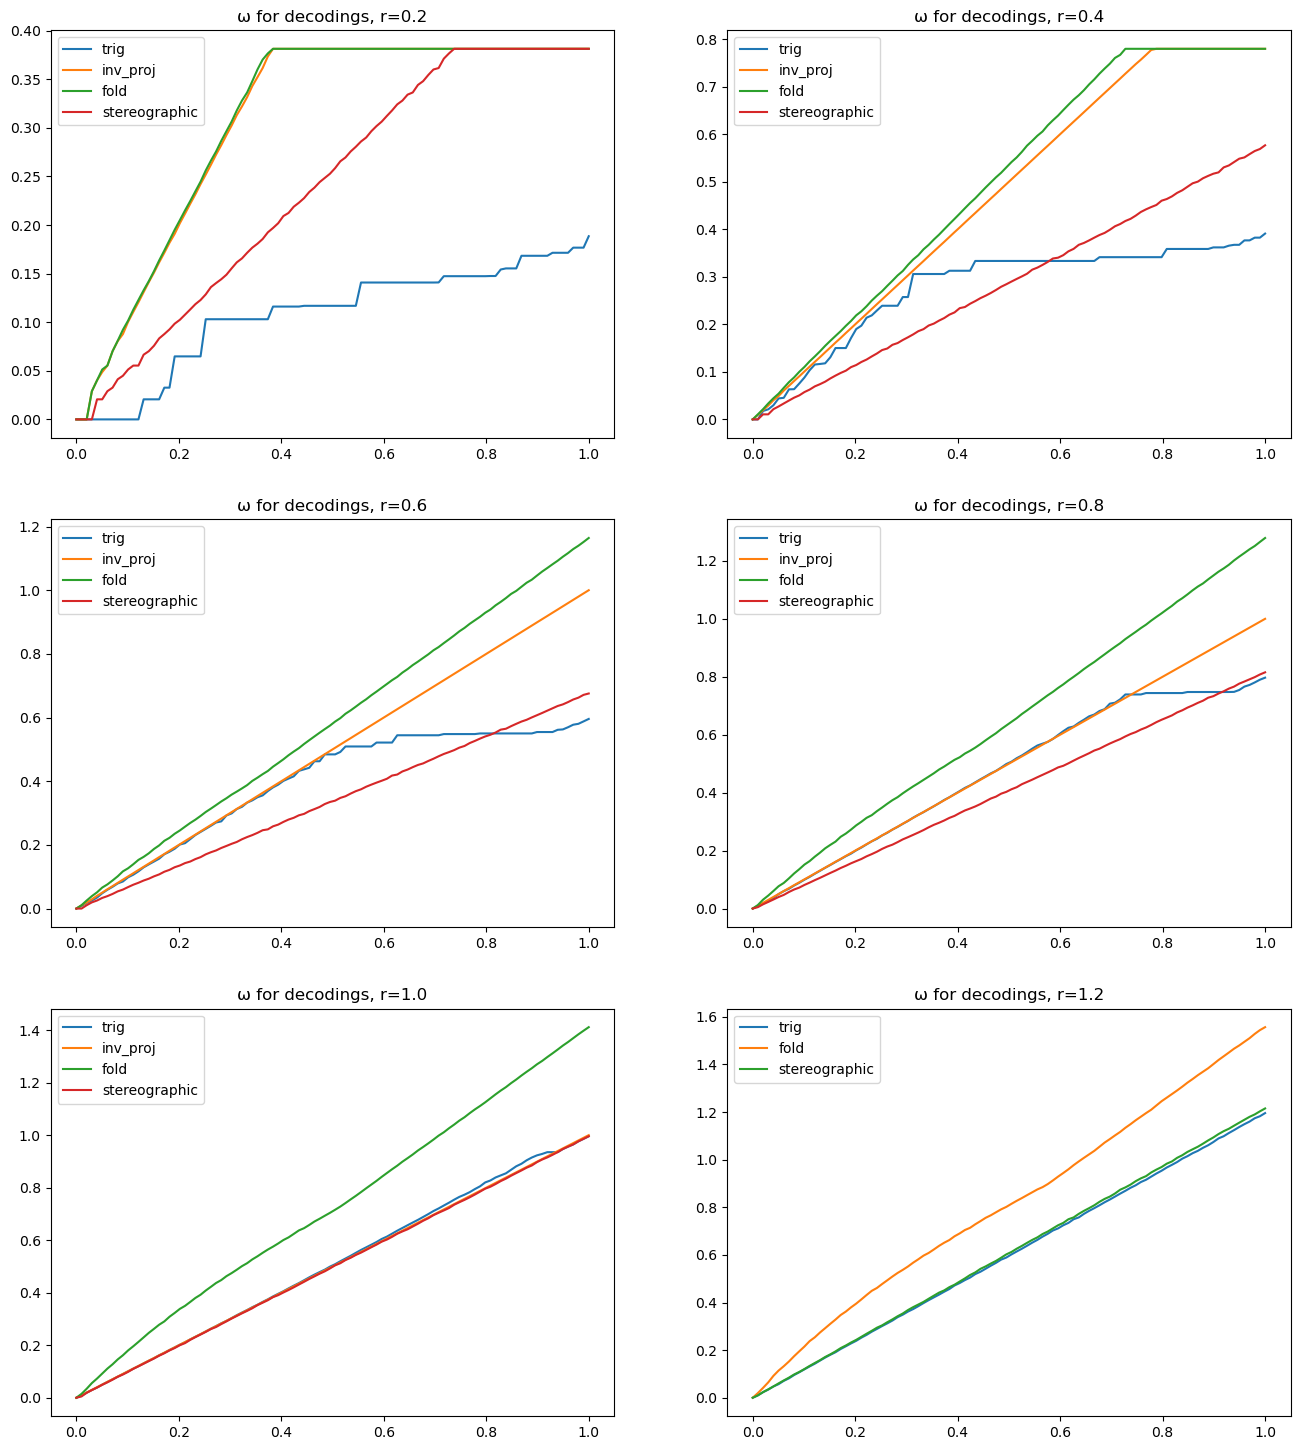

In [103]:
methods = ["trig", "inv_proj", "fold", "stereographic"]
large_r_methods = ["trig", "fold", "stereographic"]
rs = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
n_samples = 20_000
d = 3

n_cols = 2
n_rows = int(jnp.ceil(len(rs) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axs = axs.flatten()

for i, r in enumerate(rs):
  X = jax.random.normal(key=rngs[0], shape=(n_samples, d))
  X_ball = X[jnp.linalg.norm(X, axis = -1) <= r]
  methods_to_plot = methods if r <= 1.0 else large_r_methods
  for method in methods_to_plot:
    plot_omega(X_ball, method, axs[i])

  axs[i].set(title = f"\u03c9 for decodings, r={r}")
  axs[i].legend()
plt.show()